In [1]:
import argparse
import multiprocessing
import os
from importlib import import_module
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import DataLoader
from dataset import temp_dataset
import numpy as np
from tqdm import tqdm

import platform
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import easydict
args = easydict.EasyDict({
    'batch_size':100,
    'resize':(512,512),
    'data_dir': '/dataset/mo2cap_dataset/test_data/test_data/olek_outdoor',
    'dataset':'temp_dataset',
    'model':'TempModel',
    'model_dir': '/workspace/2d_to_3d/apps/exp370',
    'output_dir': '/workspace/2d_to_3d/output'
})

In [3]:

def load_model(saved_model, device):
    model_cls = getattr(import_module("model"), args.model)
    model = model_cls()

    # tarpath = os.path.join(saved_model, 'best.tar.gz')
    # tar = tarfile.open(tarpath, 'r:gz')
    # tar.extractall(path=saved_model)

    model_path = os.path.join(saved_model, 'best.pth')
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model


In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import cv2
import glob

class mo2cap_dataset(Dataset):
	def __init__(self,data_dir,resize=(512,512)) -> None:
		self.data_dir = data_dir
		self.IMAGE = self._load_data(self.data_dir)
	
	def _get_path(self,idx,datadict):
		return datadict['data_paths'][idx]
	
	def _load_data(self,dataroot):
		extension = '*.jpg'
		path_ = sorted(glob.glob(os.path.join(dataroot,extension)))
		
		return {
			'data_paths' : path_,
			'len' : len(path_)
		}
	
	def _get_rgba(self,img_path,resize=(512,512)):
		img = cv2.imread(img_path,cv2.IMREAD_COLOR)
		img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
		img = cv2.flip(img,0)
		# img = img[250:1000,:1280,:]
		# h,w,c = img.shape
		# c_h,c_w = h//2,w//2
		# radius = min(c_h,c_w) - 52
		# mask = np.zeros_like(img)
		# cv2.circle(mask, (c_w+40,c_h+52), radius, (255, 255, 255), -1)
		h,w,c = img.shape
		c_h,c_w = h//2,w//2
		radius = 920//2
		mask = np.zeros_like(img)
		cv2.circle(mask, (c_w,c_h+110), radius, (255, 255, 255), -1)
		cropped_img = cv2.bitwise_and(img, mask)
		cropped_img = cropped_img[224:,:,:]

		# M = np.float32([[1, 0, 40], [0, 1, 0]])  # Transformation matrix for translation
		# translated_img = cv2.warpAffine(cropped_img, M, (1024, 800))

		transform = transforms.Compose([
			transforms.ToPILImage(),
			transforms.Resize(resize, Image.BILINEAR),
			transforms.ToTensor(),
			# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
		])
		return transform(cropped_img)

	def __len__(self):
		return self.IMAGE['len']
	
	def __getitem__(self, index):
		img_path = self._get_path(index,self.IMAGE)
		image = self._get_rgba(img_path)
		return {'image':image}


In [5]:
split_token = '/' if 'Linux' in platform.platform() else '\\'
ktree_pred = [-1,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9,  9, 12, 13,
		14, 16, 17, 18, 19, 20, 21, 15, 20, 25, 26, 20, 28, 29, 20, 31, 32,
		20, 34, 35, 20, 37, 38, 21, 40, 41, 21, 43, 44, 21, 46, 47, 21, 49,
		50, 21, 52, 53]

ktree_label = [-1,0,0,0,1,2,3,4,5,6,7,8,9,12,12,13,14,15,16,17,18,12]
xR_2_SMPL=[2,31,61,62,27,57,63,4,34,64,29,59,0,28,58,1,3,33,5,35,6,36,11,41]
skip_num = []

def depth_viewer(input_images, features):
	temp_input_images=input_images.clone().detach().cpu()
	temp_features=features.clone().detach().cpu()
	# temp_labels=labels.clone().detach().cpu()
	fig,ax = plt.subplots(len(input_images[:10]),2,figsize=(10, 70))

	for i,(input_image, feature) in enumerate(zip(temp_input_images[0:100:10], temp_features[0:100:10])):

		input_image=to_pil_image(input_image)
		feature=to_pil_image(feature)
		# label=to_pil_image(label)
		ax[i][0].set_title('input image')
		ax[i][0].imshow(input_image )
		ax[i][1].set_title('pred_depth_feature')
		ax[i][1].imshow(feature)
		# ax[i][2].set_title('depth_GT')
		# ax[i][2].imshow(label)



	return fig  


def heatmap_viewer(input_images, heatmaps):
	temp_input_images = input_images.clone().detach()
	temp_heatmaps = heatmaps.clone().detach().cpu()
	# temp_labels = labels.clone().detach().cpu()
	fig, ax = plt.subplots(len(input_images[:10]),2,figsize=(10,70))

	for i,(input_image, heatmap) in enumerate(zip(temp_input_images[0:100:10], temp_heatmaps[0:100:10])):


		input_image = to_pil_image(input_image)
		total_heatmap = torch.zeros(heatmap.shape[1:])
		for j in range(len(heatmap)):
			total_heatmap += heatmap[j,:,:]

		# total_label = torch.zeros(heatmap.shape[1:])
		# for j in range(len(label)):
		# 	total_label += label[j,:,:]

		ax[i][0].set_title('image')
		ax[i][0].imshow(input_image)
		ax[i][1].set_title('pred_heatmap')
		ax[i][1].imshow(total_heatmap)
		# ax[i][2].set_title('heatmap_GT')
		# ax[i][2].imshow(total_label)


	return fig 

def joint_3d_viewer(input_images, joints):
	temp_input_images = input_images.clone().detach().cpu()
	# temp_labels = labels.clone().detach().cpu()
	temp_joints = joints.clone().detach().cpu()
	fig,ax = plt.subplots(len(input_images[:10]),2,figsize=(10,70),subplot_kw={"projection":"3d"})
	for i in range(len(input_images[:10])):
		rows, cols, start, stop = ax[i][0].get_subplotspec().get_geometry()
		ax[i][0].remove()
		ax[i][0] = fig.add_subplot(rows,cols,start+1)
	
	for i,(input_image, joint) in enumerate(zip(temp_input_images[0:100:10], temp_joints[0:100:10])):
		input_image=to_pil_image(input_image)

		# SMPL joints line plot
		for j in reversed(range(len(joint))):
			if not j:break
			if j in skip_num : continue
			pred_joint_line_x=[joint[j,0],joint[ktree_label[j],0]]
			pred_joint_line_y=[joint[j,1],joint[ktree_label[j],1]]
			pred_joint_line_z=[joint[j,2],joint[ktree_label[j],2]]
			ax[i][1].plot(pred_joint_line_x, pred_joint_line_y, pred_joint_line_z)
			# label_joint_line_x=[label[j,0],label[ktree_label[j],0]]
			# label_joint_line_y=[label[j,1],label[ktree_label[j],1]]
			# label_joint_line_z=[label[j,2],label[ktree_label[j],2]] 
			# ax[i][2].plot(label_joint_line_x,label_joint_line_y, label_joint_line_z)

		# for j in reversed(range(len(label))):
		# 	if not j:break
		# 	if j in skip_num : continue

		# 	label_joint_line_x=[label[j,0],label[ktree_label[j],0]]
		# 	label_joint_line_y=[label[j,1],label[ktree_label[j],1]]
		# 	label_joint_line_z=[label[j,2],label[ktree_label[j],2]] 

		# 	ax[i][2].plot(label_joint_line_x,label_joint_line_y, label_joint_line_z)
		
		ax[i][0].set_aspect('equal')
		ax[i][1].set_aspect('equal')
		# ax[i][2].set_aspect('equal')
		ax[i][1].view_init(-30,60,180)
		# ax[i][2].view_init(-30,60,180)
		ax[i][1].set_xlabel('x')
		ax[i][1].set_ylabel('y')
		ax[i][1].set_zlabel('z')
		# ax[i][2].set_ylabel('y')
		# ax[i][2].set_xlabel('x')
		# ax[i][2].set_zlabel('z')
		
		ax[i][0].imshow(input_image)

		ax[i][0].set_title('image')
		ax[i][1].set_title('pred_3d_joint')
		# ax[i][2].set_title('3d_joint_GT')
	# plt.show()
	return fig

In [6]:
@torch.no_grad()
def inference(args):
	use_cuda = torch.cuda.is_available()
	device = torch.device("cuda" if use_cuda else "cpu")

	model = load_model(args.model_dir, device).to(device)
	model = torch.nn.DataParallel(model,device_ids=[0,1])
	model.eval()

	# img_root = os.path.join(data_dir, 'images')
	# info_path = os.path.join(data_dir, 'info.csv')
	# info = pd.read_csv(info_path)

	# img_paths = [os.path.join(img_root, img_id) for img_id in info.ImageID]
	# dataset = temp_dataset(img_paths, args.resize)

	# dataset_module = getattr(import_module("dataset"), args.dataset) 
	# dataset = dataset_module(
	# 	dataroot=args.data_dir,
	# 	mode = 'test'
	# )
	
	dataset = mo2cap_dataset(args.data_dir)

	loader = torch.utils.data.DataLoader(
		dataset,
		batch_size=args.batch_size,
		# num_workers=multiprocessing.cpu_count() // 2,
		num_workers=0,
		shuffle=False,
		pin_memory=use_cuda,
		drop_last=False,
	)

	print("Calculating inference results..")
	preds = torch.tensor([])
	
	for idx,batch in enumerate(tqdm(loader)):
		inputs = {'image' : batch['image'].to(device)}
		pred = model(inputs,is_train=False)
		
		temp_joints = pred['regressor2_dict']['kp_3d_world_raw']
		indices = torch.tensor([12,21,19,17,16,18,20,2,5,8,11,1,4,7,10]).to(temp_joints.device)
		temp_joints = torch.index_select(temp_joints,1,indices)
		preds = torch.cat((preds.to(temp_joints.device),temp_joints),dim=0)
		if (idx+1)%1 == 0:
			heat_fig = heatmap_viewer(inputs['image'],pred['heatmap'])
			depth_fig = depth_viewer(inputs['image'],pred['depth_feature'])
			joint_fig = joint_3d_viewer(inputs['image'],pred['regressor2_dict']['kp_3d_cam'])
			heat_fig.savefig(f'/workspace/2d_to_3d/apps/eval_data/heat_fig_224/frame-{idx}.png')
			depth_fig.savefig(f'/workspace/2d_to_3d/apps/eval_data/depth_fig_224/frame-{idx}.png')
			joint_fig.savefig(f'/workspace/2d_to_3d/apps/eval_data/joint_fig_224/frame-{idx}.png')
			plt.close(heat_fig)
			plt.close(depth_fig)
			plt.close(joint_fig)
	
	print(preds.shape)
	preds_numpy = preds.cpu().numpy()
	np.save('/workspace/2d_to_3d/apps/eval_data/olek_outdoor_preds_224.npy',preds_numpy)




In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()
raise

RuntimeError: No active exception to reraise

In [ ]:
"""
temp1 = torch.randn(10, 25, 3)

# Define the indices you want to extract from the 1st dimension (size 25)
indices = torch.tensor([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])

# Extract the specified indices using the torch.index_select() function
sliced_tensor = torch.index_select(temp1, 1, indices)
"""

'\ntemp1 = torch.randn(10, 25, 3)\n\n# Define the indices you want to extract from the 1st dimension (size 25)\nindices = torch.tensor([0, 2, 4, 6, 8, 10, 12, 14, 16, 18])\n\n# Extract the specified indices using the torch.index_select() function\nsliced_tensor = torch.index_select(temp1, 1, indices)\n'

Calculating inference results..


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_148766/2581452595.py:46: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.Resize(resize, Image.BILINEAR),
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/28 [00:08<?, ?it/s]


IndexError: index 10 is out of bounds for axis 0 with size 10

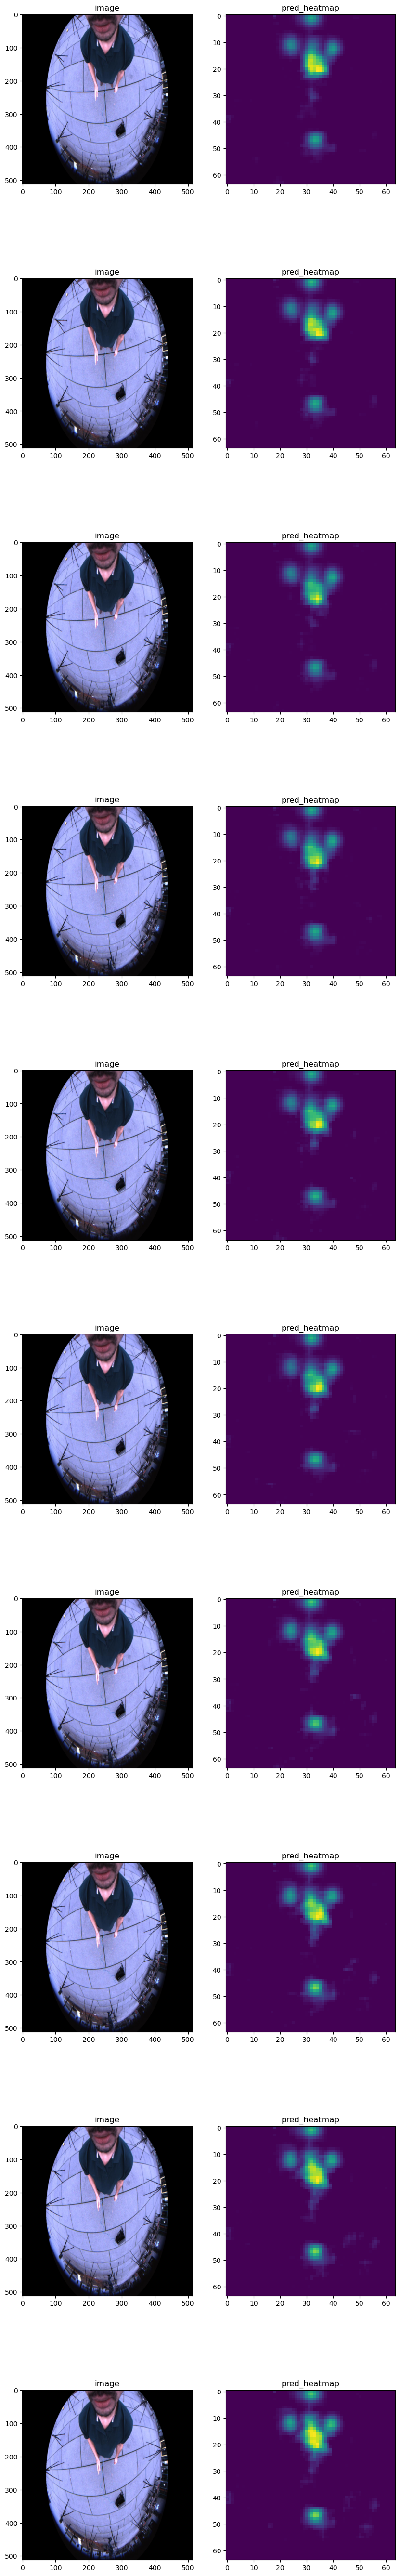

In [8]:
inference(args)